# Data Processing for the Kaggle Titanic Dataset
Author: Benjamin D Hamilton

The purpose of this workbook is to examine the features for the Titanic training set
Transform them, and create new features for exploration with the model

The previous study I performed (the Capstone for my Microsoft Certification) focused on exploring models, using a straightforward processing set for the data.

This study focuses deliberately on things like encoding variables, feature analysis and outlier handling. Lots of it!

The exploration here will be the basis for the pipeline used to treat the data for modelling.

In [233]:
#Import packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

import re

### Data Dictionary

***Initial Variable Definition Key***

- survival	-- Survival	0 = No, 1 = Yes
- pclass	-- Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd


- sex	Sex	
    Age	Age in years	
- sibsp	# of siblings / spouses aboard the Titanic	
- parch	# of parents / children aboard the Titanic	
- ticket	Ticket number	
- fare	Passenger fare	
- cabin	Cabin number	
- embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

***Variable Notes***


***pclass:*** A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

***age:*** Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

***sibsp:*** The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

***parch:*** The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

### ***Generated Features (A summary of what this workbook does)***
#### Note: Dropping features will be dealt with in a later notebook.

- ***Title*** = (str) Title extracted from passenger name (Mr Miss Dr Lady, etc)
- ***Last_Name*** = (str) Last name extracted from passenger name
- ***Last_Name_Count*** = (int) Total number of people sharing that last name
- ***Military*** = 1 if passenger has a military rank for a title, else 0
- ***Nobility*** = 1 if passenger has a nobility title, else 0
- ***Reverend*** = 1 if passenger has reverend for a title, else 0
- ***Doctor*** = 1 if passenger has Dr for a title, else 0


- ***Title_New*** (and ***MMMM***) = (str) Gender based titles (Mr, Mrs, Master, Miss)
    - When one of these 4 was not given (ex: for a doctor or reverend), one was assigned
    
Dummies for ***Title_New***:
- ***Master*** = 1 if passenger title is Master, exclusive to young men
- ***Miss*** = 1 if passenger is assigned Miss in MMMM, else 0
- ***Mrs*** = 1 if passenger is assigned Mrs in MMMM, else 0
- ***Mr*** = 1 if passenger is assigned Mr title, else 0
- Notes: Only 3 of the 4 are needed in models where colinearity is a problem

- ***female*** = 1 if passenger is female, else 0
- ***male*** = 1 if passenger is male, else 0

Dummies for ***Embarked***:
- ***Emb_C*** = 1 if Embarked was "C", else 0
- ***Emb_Q*** = 1 if Embarked was "Q", else 0
- ***Emb_S*** = 1 if Embarked was "S", else 0 
- Notes:
    - Two data were missing. They were easily imputed.
    - Only 2 of the 3 are used if colinearity is a problem
    - 2 data were "Q", so it is most likely to be dropped later

Encoding for ***Cabin***:
- ***Has Cabin*** = 1 if data is present, 0 if not (Cabin has many NAN's)
- ***Cabin Letter*** = First letter of the Cabin feature: many each from A, B, C, D, E, F... four from G... one T 
- ***A, B, C, D, E, F, G, T*** = Binary dummy variables for ***Cabin Letter***
- ***G_Level*** = 1 if G is located anywhere in sample's ***Cabin*** feature (not just first letter), 7 total

Encoding for ***PClass***:
- ***Class_1, Class_2, Class_3*** = binary dummy variables for PClass

***Age*** Outliers and Imputation Handling:
- ***Age_No_Out***: ***Age*** Outlier boundary is 3-sigma, outliers are brought to 3-sigma line
- ***Age_Imp_Mean***: NANs (>100) are imputed with feature mean
- ***Age_Imp_Median***: NANs are imputed with feature median
- ***Age_Cat_1***: ***Age*** (no outlier treatment) split into 8 hierarchcal categories (the _1 is in case I try other splits)

***Fare*** Outliers and Imputation Handling:
- ***Fare_No_Out***: ***Fare*** outliers brought within 3 sigma boundary
    - Note: this manipulation shrinks the mean, range and sigma, creating new (though less extreme) outliers
- ***Fare_No_Out_2***: ***Fare_No_Out*** outliers brought with its 3 sigma boundary
    - Note: Again, this creates new outliers, but they are much less extreme than those for ***Fare***
- ***Fare_Log***: Logrithm of ***Fare***+1 (outliers intact) to make the data less skewed
- ***Fare_Log_No_out***: ***Fare_Log*** Treated for outliers in the same way as the others
- ***Free_Ticket***: 1 if the Fare was 0, which also meant the Fare_Log was 0 (Fare_Log = Log(Fare+1))

Exploring ***Family***:
- ***Family***: Sum of SibSp (Sibling/Spouse) and Parch (Parent/Child) variables, +1 for the passenger themself.
    - In theory, # of important people onboard
- ***Family_Log***: Log of ***Family***, because distribution is skewed
- ***Family_Inv***: Reciprocal of ***Family***, just because I'm curious

Fare Individualization - split fare cost equally over each person on the same ticket
- ***Ticket_Ct***: Number of people in the training data who share a ticket number
- ***Fare_Indiv***: ***Fare*** divided by the larger of ***Family*** or ***Ticket_Ct***
    - ***Family*** accounts for all cases except where unrelated people share a ticket
    - ***Ticket_Ct*** is the alternative, but may have some error if a ticketmate is in the test set

## LET'S BEGIN:

TODO
- Import data
- Screen basic infomation

In [234]:
#Import training data
train = pd.read_csv('./datasets/train.csv')

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [235]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [236]:
#Large quantities of nulls in age and cabin
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Name: Passenger Title Features

TODO: 
- Extract Titles from Name
- Extract Last Name from Name
- Add Column of Last Name Multiplicity -> 
    - interested in how it differs from the Sibling/Spouse, Parent, and Aggregate Values

In [237]:
#This regex expression will extract titles from the name feature
#using the comma, space and period as anchors
#ie: 'Lastname, Title. Firstname' becomes ', Title.'
p = re.compile(',\s[a-zA-Z0-9_]*')

train['Title'] = train.Name.apply(lambda x: p.search(str(x)).group()[2:])

#Another regex expression that gets the last name from the name feature
#by using the comma as an anchor
#ie: 'Lastname, Title. Firstname' becomes 'Lastname,"
q = re.compile('[\S ]*,')

train['Last_Name'] = train.Name.apply(lambda x: q.search(str(x)).group()[:-1])

#Add column of last name multiplicity
train['Last_Name_Count'] = train.Last_Name.apply(lambda x: train.Last_Name.value_counts().loc[str(x)])

TODO:
 
- Create secondary binary categories for titles with common backgrounds (military, nobility, reverend, doctor)

In [238]:
ranking = ['Capt','Col','Major']
train['Military'] = train.Title.apply(lambda x: (x in ranking) * 1)  #the 1 makes it 1 and 0

nobility = ['Sir','Lady','Jonkheer','Don','Duchess','the']  #'the' is the actual duchess entry here
train['Nobility'] = train.Title.apply(lambda x: (x in nobility) * 1)

reverend = ['Rev']
train['Reverend'] = train.Title.apply(lambda x: (x in reverend) * 1)

doctor = ['Dr']
train['Doctor'] = train.Title.apply(lambda x: (x in doctor) * 1)

TODO:
- Use gender and gender-based titles to assign every passenger one of Miss, Mrs, Mr, Master
- Note for test set workup: titles with multiple words ("the duchess") not supported by my simple regex 

In [239]:
#New text column name
train['Title_New'] = train.Title

#Replace Mlle with Miss
#Replace Mme with Mrs
#Replace Ms with Miss
titles_dict = {'Mlle': 'Miss', 'Mme': 'Mrs', 'Ms': 'Miss'}
train.Title_New.replace(titles_dict, inplace = True) #Needs inplace = True



In [240]:
#There was 1 female doctor
#2 female nobles included "the" duchess. My regex only caught the first word so I compensate for that here
#Keep an eye out for strange titles in the test set!
train.loc[train[(train.Title_New == 'Dr') & (train.Sex=='female')].index,'Title_New'] = 'Mrs'
train.loc[train[(train.Title_New == 'Lady') | (train.Title_New=='the')].index,'Title_New'] = 'Mrs'

#Men are a bit easier because all boys are automatically called Master
#Thus, any non-Master men becomes a Mr
train.loc[train[(train.Sex == 'male') & (train.Title != 'Master')].index,'Title_New'] = 'Mr'

#Copy the feature for easy in bookkeeping during workup
train['MMMM']=train.Title_New

In [241]:
train.Title_New.unique()

array(['Mr', 'Mrs', 'Miss', 'Master'], dtype=object)

TODO:
- Create dummy variables for the 4 gender titles 
    - NB: 1 may need deleting later to prevent colinearity
- Create Dummies for gender 
    - 1 will definitely be deleted later
- Create dummies for Embarkation Point 
    - 1 may be deleted later

In [242]:
train = pd.concat([train,pd.get_dummies(train.MMMM)],axis=1)     #Gender titles
train = pd.concat([train,pd.get_dummies(train.Sex)],axis=1)      #Gender

In [243]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Reverend,Doctor,Title_New,MMMM,Master,Miss,Mr,Mrs,female,male
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,Mr,Mr,0,0,1,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,0,Mrs,Mrs,0,0,0,1,1,0


In [244]:
train.Embarked.unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [245]:
train = pd.concat([train,pd.get_dummies(train.Embarked,prefix='Emb')],axis=1)   #Embarkation Point

In [246]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'Last_Name',
       'Last_Name_Count', 'Military', 'Nobility', 'Reverend', 'Doctor',
       'Title_New', 'MMMM', 'Master', 'Miss', 'Mr', 'Mrs', 'female', 'male',
       'Emb_C', 'Emb_Q', 'Emb_S'],
      dtype='object')

# Cabin
TODO:
- Create a feature for if Cabin Data is present (most of it is missing)
- Extract First Cabin Letter from Cabin Feature
    - Some cabins have multiple letters (suites), usually on the same level so first letter will suffice
    - Main cabins are on A, B, C, D, E, F
    - Rarely: T
    - G occurs very rarely and sometimes after other letters. It is categorized separately.

In [247]:
#Count missing data
train.Cabin.isnull().sum()

687

In [248]:
#List of every cabin in the data that is shown
train.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27',
       'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'E31',
       'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101', 'F E69', 'D47',
       'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32', 'B4',
       'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35', 'C87', 'B77',
       'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D',
       'C22 C26', 'C106', 'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7',
       'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'T', 'C128', 'D37',
       'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44', 'A34', 'C104', 'C111',
       'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30', 'D20',
       'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22', 'C86',
       'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20', 'D19',
       'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126', 'B71',
       'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64', 'E24',

In [249]:
train['Has_Cabin'] = ~train.Cabin.isnull() * 1

#Extract the cabin letter into the new feature
#If a sample has no cabin info, leave a null
train['Cabin_Letter'] = train.Cabin
train.loc[train[~train.Cabin_Letter.isnull()].index,'Cabin_Letter'] = \
train[~train.Cabin_Letter.isnull()].Cabin_Letter.apply(lambda x: re.search('[A-Z]',str(x)).group())

#Cabin letter Dummies
train = pd.concat([train,pd.get_dummies(train.Cabin_Letter)],axis=1)

#G!
train['G_Level'] = train.Cabin.str.contains('G') * 1

In [250]:
train.Cabin_Letter.unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [251]:
train.Cabin_Letter.value_counts()
#Note 4 G here = 4 cabin entries started with G

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Cabin_Letter, dtype: int64

In [252]:
train.G_Level.sum()
#Note 7 G here means 3 of them were embedded in cabin info

7

### Class Dummies
TODO:
- 3 classes are given as 1, 2, 3. Will keep that.
- Create 3 class dummies.

In [253]:
Class_Dummies = pd.get_dummies(train.Pclass,prefix='Class',prefix_sep='_')
train = pd.concat([train,Class_Dummies],axis=1)

In [254]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,C,D,E,F,G,T,G_Level,Class_1,Class_2,Class_3
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,NaN,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,1,0,0,0,0,0,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,NaN,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,1,0,0,0,0,0,0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,0,0,0,NaN,0,0,1


In [255]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'Last_Name',
       'Last_Name_Count', 'Military', 'Nobility', 'Reverend', 'Doctor',
       'Title_New', 'MMMM', 'Master', 'Miss', 'Mr', 'Mrs', 'female', 'male',
       'Emb_C', 'Emb_Q', 'Emb_S', 'Has_Cabin', 'Cabin_Letter', 'A', 'B', 'C',
       'D', 'E', 'F', 'G', 'T', 'G_Level', 'Class_1', 'Class_2', 'Class_3'],
      dtype='object')

# Age Features
TODO:
- Examine Age spreads
- Apply 3 std dev outlier identification
- Treat Outliers by resetting them as the maximum age before outliers

In [256]:
#No_Out means no outlier. Start with the base age feature.
train['Age_No_Out']=train.Age

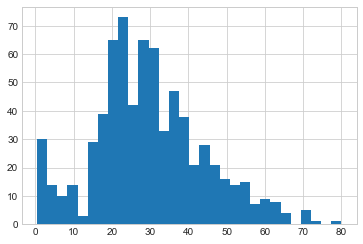

In [257]:
#examine age distribution
train.Age_No_Out.hist(bins=30)

- There is a clear bump for young people
- Long tail out to 80 or so
- May want to treat those separately if I can.

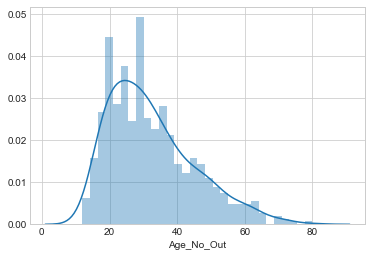

In [258]:
#Take a look without the young people
sns.distplot(train.Age_No_Out[train.Age_No_Out >= 12 ],kde=True,bins=30)

In [259]:
train_stats = train.Age_No_Out[train.Age_No_Out >= 12 ].dropna().describe()
train_stats

count    646.000000
mean      32.334365
std       12.613717
min       12.000000
25%       22.000000
50%       30.000000
75%       40.000000
max       80.000000
Name: Age_No_Out, dtype: float64

In [260]:
#3 std dev outlier range...
#This is a back of the envelope calculation
print(32 + 3 * 12.6)
print(32 - 3 * 12.6)
print(train.Age_No_Out[train.Age_No_Out > 67.8].count())

69.8
-5.799999999999997
7


In [261]:
#Calculate what the outliers should be reduced to
#1.5 x IQR
#Also back of the envelope
print(32 + 1.5 * 18)
print(32 - 1.5 * 18)
print(train.Age_No_Out[train.Age_No_Out > 57].count())

59.0
5.0
33


- Create a new column in train called Age_No_Out
- It will remove the outliers and bring to the max of the 3 sigma range
- This will change the stats a bit. Keep that in mind for later.

In [262]:
#Use a copy so I don't mess up the original
#Temp_df is the column of Fares from the training set
def std_dev_outlier_remover(df,column):
    """Input: data frame, column name of feature to handle
    Output: The column with update values to set as a dataframe column"""
    Temp_df = pd.DataFrame(train[[column]].copy()) 

    #Calculate the outlier band:
    train_stats = Temp_df.dropna().describe()
    avg = train_stats.loc['mean']
    sig3 = 3 * train_stats.loc['std']
    max_band = avg + sig3
    min_band = avg - sig3

    #The dataset 
    #For each element (i) in the list of fares (Temp_df)....
    for i in range(0,len(Temp_df)):


        #Create a small 2 element array (min_max) that returns (T,F) if the elemnt is > max allowed
        # (F,T) if it is < min allowed
        # (F,F) if the element is not an outlier
        # (T,T) is impossible
        min_max = np.array([(Temp_df.iloc[i].values > max_band),(Temp_df.iloc[i].values < min_band)])

        #Create a small 2 element array that returns...
        #(a,b), a is True if element i is not null, False if it is null
        #b is True if min_max contains any True
        k = np.array([(~Temp_df.isnull().iloc[i].values), (min_max.any())])

        #If the element i from temp_df is an outlier and not null
        #ie. k.all() = True
        #Then set the outlier value to the band itself
        #NB: the outliers only exist outside the max_band (cannot have negative fares)
        #so only the max_band is treated.
        if k.all():
            Temp_df.iloc[i] = max_band

    #Create a new feature for Fares w/ no Outliers
    return Temp_df
    
#train['Age_No_Out'] = Temp_df
    

In [263]:
train['Age_No_Out'] = std_dev_outlier_remover(train,'Age')

TODO:
- Take a look at Age stats and nulls
- Add imputed age columns for later comparison (if desired)

In [264]:
AIStats = train.Age_No_Out.describe()
AINull = train.Age_No_Out.isnull().sum()
print("No-Outlier Age w/ Nulls: \n", AIStats)  #mean has dropped a bit ~2-3 yrs compared with above. Expected.
print("Nulls: ", AINull)   #Nulls are still there. Need to imput them.

No-Outlier Age w/ Nulls: 
 count    714.000000
mean      29.688694
std       14.492933
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       73.278610
Name: Age_No_Out, dtype: float64
Nulls:  177


**AGE IMPUTATION 1: Replace Nulls w/ Mean of Feature**

In [265]:
train['Age_Imp_Mean'] = train.Age_No_Out.fillna(AIStats.loc['mean'])

In [266]:
#works...
print("No-Outlier Age w/ Mean Imputation")
print("Nulls:",train.Age_Imp_Mean.isnull().sum())
print(train.Age_Imp_Mean.describe())

No-Outlier Age w/ Mean Imputation
Nulls: 0
count    891.000000
mean      29.688694
std       12.971973
min        0.420000
25%       22.000000
50%       29.688694
75%       35.000000
max       73.278610
Name: Age_Imp_Mean, dtype: float64


**AGE IMPUTATION 2: Replace Nulls w/ Median of Feature**

In [267]:
train['Age_Imp_Median'] = train.Age_No_Out.fillna(AIStats.loc['50%'])
print("No-Outlier Age w/ Median Imputation")
print("Nulls:", train.Age_Imp_Median.isnull().sum())
print(train.Age_Imp_Median.describe())

#Values change, only a little bit.

No-Outlier Age w/ Median Imputation
Nulls: 0
count    891.000000
mean      29.353229
std       12.989479
min        0.420000
25%       22.000000
50%       28.000000
75%       35.000000
max       73.278610
Name: Age_Imp_Median, dtype: float64


**Age Imputation bucket list: create a model for age imputation (someday)** 

TODO: 
    - Hierarchical Categorical Age Feature
    - Categories are selected that seem reasonable at a glance, can be readdressed later.
    - 8 categories, numbered 0 to 7 representing:
    - [0 to 5], [5.01 to 10.5], [10.51 to 15.5], [15.51 to 25.5] ... [55.51 to 100]

In [268]:
#AGE CATEGORIES
bins = [0,5.01,10.51,15.51,25.51,35.51,45.51,55.51,100]
cat_names = [0,1,2,3,4,5,6,7]
train['Age_Cat_1']=pd.cut(train.Age_No_Out,bins,labels=cat_names)  #deals with NAN by keeping them


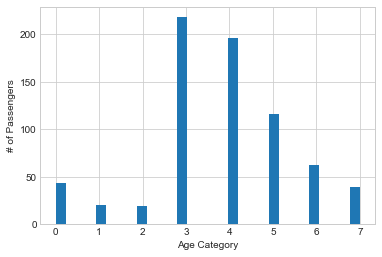

In [269]:
train.Age_Cat_1.hist(bins=30)
plt.xlabel('Age Category')
plt.ylabel('# of Passengers')
plt.show()

# Fare Features

The goal here is to create some fare features to explore during modelling.

TODO: 
- Get some basic fare statitstics

In [270]:
FareStats = train.Fare.describe()

print("Nulls: ", train.Fare.isnull().sum())
print(FareStats)

Nulls:  0
count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64


In [271]:
#Back of the envelope outlier calculations
#3stdev
print("3 stdev upper limit: ", 32.2 + 3 * 49.69)
#print("lower limit:", 32.2 - 3 * 49.69)
print("Fares above 3 std dev: ", train.Fare[train.Fare > 181.27].count())

#1.5 x IQR
print("1.5xIQR upper limit: ", 32.2 + 1.5 * (31 - 7.91))
#print("lower limit:",32.2 - 1.5 * (31 - 7.91))
print("Fares above 1.5xIQR: ", train.Fare[train.Fare > 114].count())

3 stdev upper limit:  181.26999999999998
Fares above 3 std dev:  20
1.5xIQR upper limit:  66.83500000000001
Fares above 1.5xIQR:  42


Text(0,0.5,'Passengers in Bin')

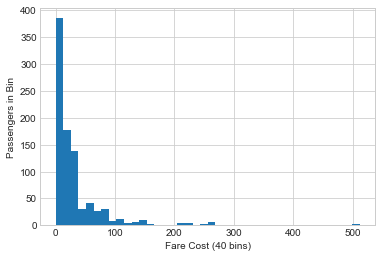

In [272]:
train.Fare.hist(bins=40)
plt.xlabel('Fare Cost (40 bins)')
plt.ylabel('Passengers in Bin')
#Way skewed!

TODO:
- Fare Outlier Treatment
    - 3 std dev limit
    - fares in excess will be brought to upper limit

In [273]:
#3sig
print(32.2 + 3 * 49.69)
print(train.Fare[train.Fare > 181.27].count())

181.26999999999998
20


In [274]:
train['Fare_No_Out'] = std_dev_outlier_remover(train,'Fare')

In [275]:
train.Fare_No_Out.describe()

count    891.000000
mean      30.003893
std       36.989591
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      181.284494
Name: Fare_No_Out, dtype: float64

Text(0,0.5,'Passengers in Bin')

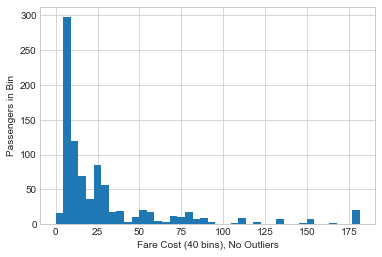

In [276]:
train.Fare_No_Out.hist(bins=40)
plt.xlabel('Fare Cost (40 bins), No Outliers')
plt.ylabel('Passengers in Bin')
#Looks quite a bit different from original
#Still quite skewed, there may be more to do here.

TODO:
- Add a second consecutive Outlier Treatment
- Same method
- Stored as an additional feature for later exploration

In [277]:
train['Fare_No_Out_2'] = std_dev_outlier_remover(train,'Fare_No_Out')

In [278]:
train.Fare_No_Out_2.describe()

count    891.000000
mean      28.943399
std       33.054160
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      140.972666
Name: Fare_No_Out_2, dtype: float64

Text(0,0.5,'Passengers in Bin')

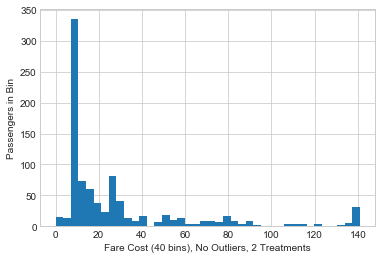

In [279]:
train.Fare_No_Out_2.hist(bins=40)
plt.xlabel('Fare Cost (40 bins), No Outliers, 2 Treatments')
plt.ylabel('Passengers in Bin')
#Curious about the impact of having that growing stack at ~140
#Skew is still pretty bad.
#Time to log.

**Bucket-List: Categorize the fares (maybe someday)**

**FARE LOGARITHMS**

TODO
- Create Log Fare Features
- It should help with that skew problem

**...turns out, there are a number of fare = 0, nuking the logarithm**

TODO:
- Add 1 to all the Fares
- Also note that this is calculated from the Fares prior to their outlier treatment

In [280]:
dft = pd.DataFrame(np.log(train.Fare+1))

In [281]:
dft.min()

Fare    0.0
dtype: float64

In [282]:
dft.isnull().sum()

Fare    0
dtype: int64

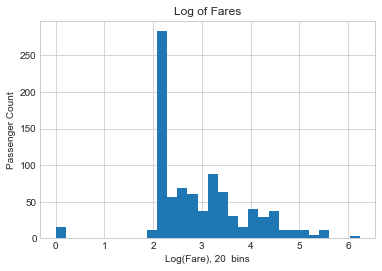

In [283]:
dft.hist(bins=30)
plt.title('Log of Fares')
plt.xlabel('Log(Fare), 20  bins')
plt.ylabel('Passenger Count')
plt.show()

In [284]:
train[train.Fare == 0].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,G_Level,Class_1,Class_2,Class_3,Age_No_Out,Age_Imp_Mean,Age_Imp_Median,Age_Cat_1,Fare_No_Out,Fare_No_Out_2
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,...,NaN,0,0,1,36.0,36.000000,36.0,5.0,0.0,0.0
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,...,0,1,0,0,40.0,40.000000,40.0,5.0,0.0,0.0
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,...,NaN,0,0,1,25.0,25.000000,25.0,3.0,0.0,0.0
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,...,NaN,0,1,0,NaN,29.688694,28.0,NaN,0.0,0.0
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,...,NaN,0,0,1,19.0,19.000000,19.0,3.0,0.0,0.0


TODO:
- Add the feature to the main dataframe
- Check out basic stats
- Then look at the outliers

In [285]:
#Add the feature to the training set dataframe
train['Fare_Log'] = pd.DataFrame(np.log(train.Fare+1))

In [286]:
train.Fare_Log.describe()
#THe "0"s are outliers

count    891.000000
mean       2.962246
std        0.969048
min        0.000000
25%        2.187218
50%        2.737881
75%        3.465736
max        6.240917
Name: Fare_Log, dtype: float64

In [287]:
#3sig
print("Upper Limit:", 2.96 + 3 * 0.96)
print("Lower Limit:", 2.96 - 3 * 0.96)
print("High Outliers:", train.Fare_Log[train.Fare_Log >5.84].count())
print("Low Outliers:", train.Fare_Log[train.Fare_Log <0.08].count())

Upper Limit: 5.84
Lower Limit: 0.08000000000000007
High Outliers: 3
Low Outliers: 15


TODO: 
- Log Fare Outlier Handling
    - Create one binary feature saying whether the original Fare_Log was for a free ticket
        - This is because Fare_Log = 0 is the same as Log(Fare+1) when Fare = 0
    - Create a numeric feature where the outliers are brought in to the 3 std dev limit

In [288]:
#Not the most straightforward way to do this, but it is when it came up to add.
train['Free_Ticket'] = (train.Fare_Log == 0 ) * 1  
train.Free_Ticket.sum()

15

In [289]:
train['Fare_Log_No_Out'] = std_dev_outlier_remover(train,'Fare_Log')

In [290]:
train.Fare_Log_No_Out.describe()

count    891.000000
mean       3.059806
std        0.957250
min        1.611935
25%        2.188856
50%        2.778819
75%        3.526361
max        5.869391
Name: Fare_Log_No_Out, dtype: float64

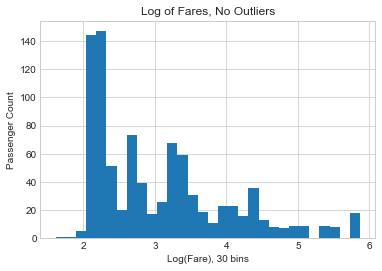

In [291]:
train.Fare_Log_No_Out.hist(bins = 30)
plt.title('Log of Fares, No Outliers')
plt.xlabel('Log(Fare), 30 bins')
plt.ylabel('Passenger Count')
plt.show()

- The distribution is a little better, but still not great. 
- Will have to compare the impact of fare treatment with models.

In [292]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'Last_Name',
       'Last_Name_Count', 'Military', 'Nobility', 'Reverend', 'Doctor',
       'Title_New', 'MMMM', 'Master', 'Miss', 'Mr', 'Mrs', 'female', 'male',
       'Emb_C', 'Emb_Q', 'Emb_S', 'Has_Cabin', 'Cabin_Letter', 'A', 'B', 'C',
       'D', 'E', 'F', 'G', 'T', 'G_Level', 'Class_1', 'Class_2', 'Class_3',
       'Age_No_Out', 'Age_Imp_Mean', 'Age_Imp_Median', 'Age_Cat_1',
       'Fare_No_Out', 'Fare_No_Out_2', 'Fare_Log', 'Free_Ticket',
       'Fare_Log_No_Out'],
      dtype='object')

# FAMILY FEATURES

TODO:
- Explore ways to get a count of family members
- Sum the Sibling/Spouse and Parent/Child Feature
- And more

In [293]:
#create the new feature
train['Family'] = train.Parch + train.SibSp + 1

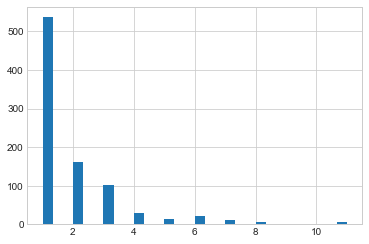

In [294]:
train.Family.hist(bins=30)

- Distribution is very skewed. Let's take a log(x+1) to see if that has more impact

In [295]:
train['Family_Log'] = np.log(train['Family'])

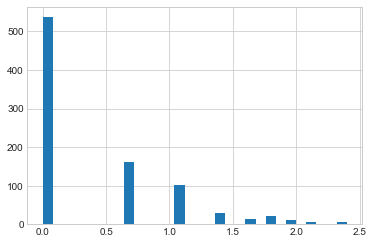

In [296]:
train.Family_Log.hist(bins=30)

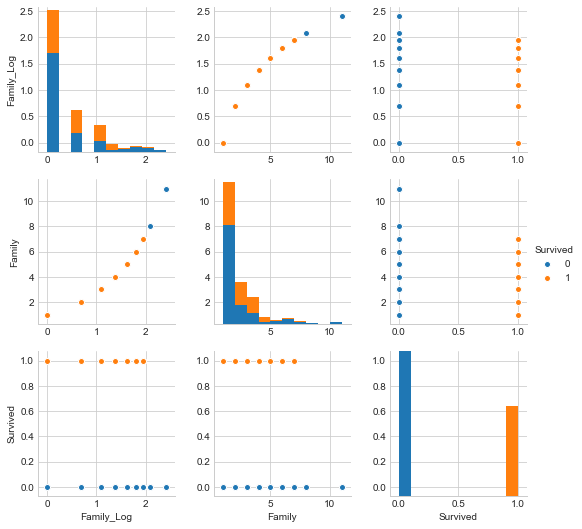

In [297]:
#Quick glance at survival vs Family Size
#Looks like big families do worse.
sns.pairplot(train[['Family_Log','Family','Survived']],hue='Survived')

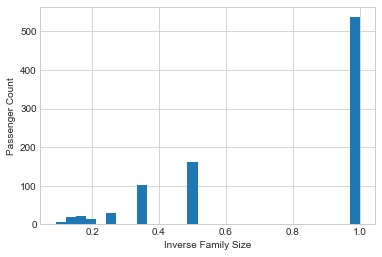

In [298]:
#Out of curiousity, I'll try a reciprocal relationship too:
train['Family_Inv'] =  1 / (train.Family)
train.Family_Inv.hist(bins=30)
plt.xlabel('Inverse Family Size')
plt.ylabel('Passenger Count')
plt.show()

## FARE REVISTED

TODO:
- Create a Fare_Indiv feature that divides the fare by the family size or ticket multiplicity (whichever is bigger)
- Then perform outlier and log transformations as done for standard Fare

***Calculate Ticket Multiplictiy***:

In [299]:
train['Ticket_Ct'] = train.Ticket.apply(lambda x: train.Ticket.value_counts().loc[str(x)])

In [300]:
train.Ticket_Ct.unique()

array([1, 2, 4, 3, 7, 5, 6], dtype=int64)

***Calculate Fare_Indiv:***

In [301]:
Fare_Prep = pd.DataFrame([(train.Fare / train.Ticket_Ct), (train.Fare / train.Family)])
train['Fare_Indiv'] = Fare_Prep.transpose().min(axis=1)

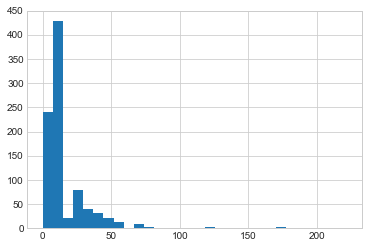

In [302]:
train.Fare_Indiv.hist(bins=30)

In [303]:
train.Fare_Indiv.describe()

count    891.000000
mean      15.463672
std       18.187769
min        0.000000
25%        7.239600
50%        8.050000
75%       14.775000
max      221.779200
Name: Fare_Indiv, dtype: float64

TODO:
- Remove Outliers
- Graph
- Stats

Note: The transformation makes outliers seem much further out.

In [304]:
train['Fare_Indiv_No_Out'] = std_dev_outlier_remover(train,'Fare_Indiv')

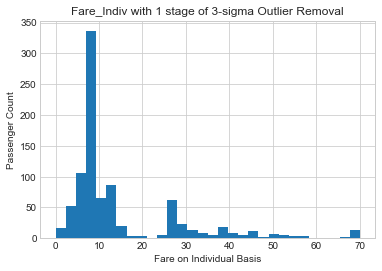

In [305]:
train.Fare_Indiv_No_Out.hist(bins=30)
plt.title('Fare_Indiv with 1 stage of 3-sigma Outlier Removal')
plt.xlabel('Fare on Individual Basis')
plt.ylabel('Passenger Count')
plt.show()

In [306]:
train.Fare_Indiv_No_Out.describe()

count    891.000000
mean      14.806993
std       13.852085
min        0.000000
25%        7.239600
50%        8.050000
75%       14.775000
max       70.026978
Name: Fare_Indiv_No_Out, dtype: float64

***2nd Round of Outlier Removal***

In [307]:
train['Fare_Indiv_No_Out_2'] = std_dev_outlier_remover(train,'Fare_Indiv_No_Out')

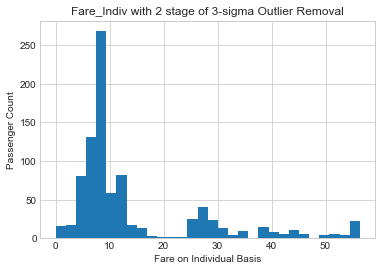

In [308]:
train.Fare_Indiv_No_Out_2.hist(bins=30)
plt.title('Fare_Indiv with 2 stage of 3-sigma Outlier Removal')
plt.xlabel('Fare on Individual Basis')
plt.ylabel('Passenger Count')
plt.show()

- Still pretty far out there. Will just leave it like this for now and compare to the others later

In [309]:
train.Fare_Indiv_No_Out_2.describe()

count    891.000000
mean      14.566013
std       12.983722
min        0.000000
25%        7.239600
50%        8.050000
75%       14.775000
max       56.363248
Name: Fare_Indiv_No_Out_2, dtype: float64

***Logarithms***

In [310]:
train['Fare_Indiv_Log'] = np.log(train.Fare_Indiv+1)

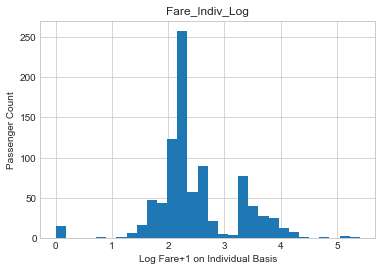

In [311]:
train.Fare_Indiv_Log.hist(bins=30)
plt.title('Fare_Indiv_Log')
plt.xlabel('Log Fare+1 on Individual Basis')
plt.ylabel('Passenger Count')
plt.show()

- The Log makes it look more distributed, except for the hole in the middle and outliers

In [312]:
train.Fare_Indiv_Log.describe()

count    891.000000
mean       2.483191
std        0.750833
min        0.000000
25%        2.108951
50%        2.202765
75%        2.758415
max        5.406181
Name: Fare_Indiv_Log, dtype: float64

***Log and Outliers***

In [313]:
train['Fare_Indiv_Log_No_Out'] = std_dev_outlier_remover(train,'Fare_Indiv_Log')

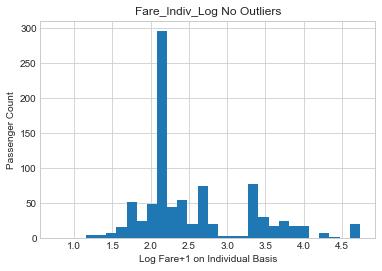

In [314]:
train.Fare_Indiv_Log_No_Out.hist(bins=30)
plt.title('Fare_Indiv_Log No Outliers')
plt.xlabel('Log Fare+1 on Individual Basis')
plt.ylabel('Passenger Count')
plt.show()

- The ~2.2 bin is getting taller, this may not be helping much
- Will have to see in modelling phase

In [315]:
train.Fare_Indiv_Log_No_Out.describe()

count    891.000000
mean       2.560578
std        0.726433
min        0.757128
25%        2.113987
50%        2.205064
75%        2.880704
max        4.735690
Name: Fare_Indiv_Log_No_Out, dtype: float64

In [316]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'Last_Name',
       'Last_Name_Count', 'Military', 'Nobility', 'Reverend', 'Doctor',
       'Title_New', 'MMMM', 'Master', 'Miss', 'Mr', 'Mrs', 'female', 'male',
       'Emb_C', 'Emb_Q', 'Emb_S', 'Has_Cabin', 'Cabin_Letter', 'A', 'B', 'C',
       'D', 'E', 'F', 'G', 'T', 'G_Level', 'Class_1', 'Class_2', 'Class_3',
       'Age_No_Out', 'Age_Imp_Mean', 'Age_Imp_Median', 'Age_Cat_1',
       'Fare_No_Out', 'Fare_No_Out_2', 'Fare_Log', 'Free_Ticket',
       'Fare_Log_No_Out', 'Family', 'Family_Log', 'Family_Inv', 'Ticket_Ct',
       'Fare_Indiv', 'Fare_Indiv_No_Out', 'Fare_Indiv_No_Out_2',
       'Fare_Indiv_Log', 'Fare_Indiv_Log_No_Out'],
      dtype='object')

In [318]:
#Save it so I can use it later, if desired.
train.to_csv('Post_Data_Workup.csv')